In [3]:
import json, sys, matplotlib, glob, pytz, sys, os, time
import numpy as np; import seaborn as sns; import pandas as pd
from datetime import datetime, date, timezone, timedelta
import urllib.request

#Graphing with Plotly: 
# import plotly.graph_objects as go

#Matplotlib: 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Make it look pretty on retina displays:
%config InlineBackend.figure_format = 'retina'

# Plotting @realDonaldTrump tweets

First, download all of Trump's tweets from TheTrumpArchive.com
https://drive.google.com/file/d/1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6/view?usp=sharing

We'll save the file as "trump_tweets.csv" for future use

In [5]:
# Read in the local file and check it out:
tweets = pd.read_csv('trump_tweets.csv')
print("Read in {} tweets".format(len(tweets)))
tweets.head(2)

Read in 56571 tweets


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f


This next part cleans the data and normalizes it to Eastern Time

In [6]:
# Cast booleans
tweets.isRetweet = tweets.isRetweet.apply(lambda b: b == 't')
tweets.isFlagged = tweets.isFlagged.apply(lambda b: b == 't')
tweets.isDeleted = tweets.isDeleted.apply(lambda b: b == 't')

# Cast Timestamp
tweets.date = tweets.date.apply(pd.Timestamp)

# Localize Dates
ET = pytz.timezone('US/Eastern')
tweets['eastern_time'] = tweets.date.apply(lambda d: ET.localize(d))

# Use the localized dates 
tweets['tz_adjusted_date'] = tweets.apply(lambda row: (row.date + row.eastern_time.utcoffset()), axis=1)
tweets['hour']   = tweets.tz_adjusted_date.apply(lambda d: d.hour)
tweets['day']    = tweets.tz_adjusted_date.apply(lambda d: d.date())
tweets['week']   = tweets.day.apply(lambda d: date(d.year, d.month, int(np.abs(np.floor(d.day/7.0)*7-3))))
tweets['month']  = tweets.tz_adjusted_date.apply(lambda d: date(d.year, d.month, 15))
tweets['year']   = tweets.day.apply(lambda d: d.year)

#This one is the trickiest, we only care about the time of day, so we'll make a fake date of 2000-01-01: 
tweets['normed_to_2000'] = tweets.tz_adjusted_date.apply(lambda d: datetime(2000,1,1,d.hour, d.minute,d.second))

#How's it look?
tweets.head(2)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,eastern_time,tz_adjusted_date,hour,day,week,month,year,normed_to_2000
0,98454970654916608,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02 18:07:48,False,2011-08-02 18:07:48-04:00,2011-08-02 14:07:48,14,2011-08-02,2011-08-03,2011-08-15,2011,2000-01-01 14:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,False,2020-03-03 01:34:50-05:00,2020-03-02 20:34:50,20,2020-03-02,2020-03-03,2020-03-15,2020,2000-01-01 20:34:50


In [7]:
_slice = pd.DataFrame( tweets[tweets.day > date(2020,1,1)] )

First question, how many tweets posted each year? 

In [8]:
print("Tweets Per Year: ")
_slice.groupby('year').aggregate({'id':'count'}).transpose()

Tweets Per Year: 


year,2020,2021
id,12205,151


In [9]:
def add_weekly_volume(ax):
    new_df = pd.DataFrame(_slice.groupby(['week','isRetweet']).aggregate({'id':'count'}).unstack())
    
    # Might need to pad up front to make it line up properly
    padding_df = pd.DataFrame([{'week':datetime(2014,10,15), 'id':0, 'isRetweet':False},
                               {'week':datetime(2014,11,15), 'id':0, 'isRetweet':False},
                               {'week':datetime(2014,12,15), 'id':0, 'isRetweet':False} ]).groupby(
        ['week','isRetweet']).aggregate({'id':'sum'}).unstack();
    
    #Need to padd the first two to make it fit properly
    pd.concat([padding_df, new_df]).plot(kind='barh', stacked=True, ax=ax)
    ax.set_facecolor('white')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.set_xlabel(None);
    ax.legend(["@realDonaldTrump Tweeting", "@realDonaldTrump Retweeting"], ncol=1, bbox_to_anchor=(2,-0.01),
              facecolor='white', framealpha=1, fontsize=13, title_fontsize=13, title="Weekly Tweet Volume")

In [10]:
def election_2020(ax):
    ax.text(y=date(2020,11,3), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="2020 US Presidential Election", fontsize=11)
    ax.hlines( y    = date(2020,11,3), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))

def first_debate_2020(ax):
    ax.text(y=date(2020,9,29), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="First Presidential Debate", fontsize=11)
    ax.hlines( y    = date(2020,9,29), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))
    
def dueling_town_halls(ax):
    ax.text(y=date(2020,10,15), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="Dueling Town Halls\n(Cancelled 2nd Debate)", fontsize=11)
    ax.hlines( y    = date(2020,10,15), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))
    
def first_task_force_presser(ax):
    ax.text(y=date(2020,3,16), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="First White House Coronavirus Task\nForce daily press conference", fontsize=11)
    ax.hlines( y    = date(2020,3,15), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))

def bleach_comment(ax):
    ax.text(y=date(2020,4,23), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="President Trump suggests\ninjecting disinfectant", fontsize=11)
    ax.hlines( y    = date(2020,4,23), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))
    
def trump_visits_church(ax):
    ax.hlines( y    = date(2020,6,2), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,0,0))

    ax.plot([datetime(2000,1,2,0,0,0), datetime(2000,1,2,0,59,0)], 
            [date(2020,6,2), date(2020,6,10)], color='k', linestyle='--', linewidth=0.75)
    
    ax.text(y=date(2020,6,8), x=datetime(2000,1,2,1,0,0), va='top', backgroundcolor='white', 
            s="Trump visits St. John’s Episcopal Church\nfor photo op with Bible", fontsize=11)

    
def withdraw_from_WHO(ax):
    ax.text(y=date(2020,7,7), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="United States withdraws from\nWorld Health Organization", fontsize=11)
    ax.hlines( y    = date(2020,7,7), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))

def george_floyd(ax):
    ax.text(y=date(2020,5,24), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="George Floyd Killed by Minneapolis Police", fontsize=11)
    ax.hlines( y    = date(2020,5,25), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))

    
def blm(ax):
    ax.text(y=date(2020,5,31), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="Black Lives Matter Protests", fontsize=11)
    ax.hlines( y    = date(2020,5,30), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))

def suspended(ax):
    ax.text(y=date(2021,1,8), x=datetime(2000,1,2,1,0,0), va='center', backgroundcolor='white', 
            s="@realDonaldTrump Suspended\nby Twitter (January 8, 2021)", fontsize=11)
    ax.hlines( y    = date(2021,1,9), color= 'k', linestyle="--", linewidth=0.75,
               xmin = datetime(2000,1,1, 0, 0, 0), xmax = datetime(2000,1,2,0,30,0))


12,356 tweets in total


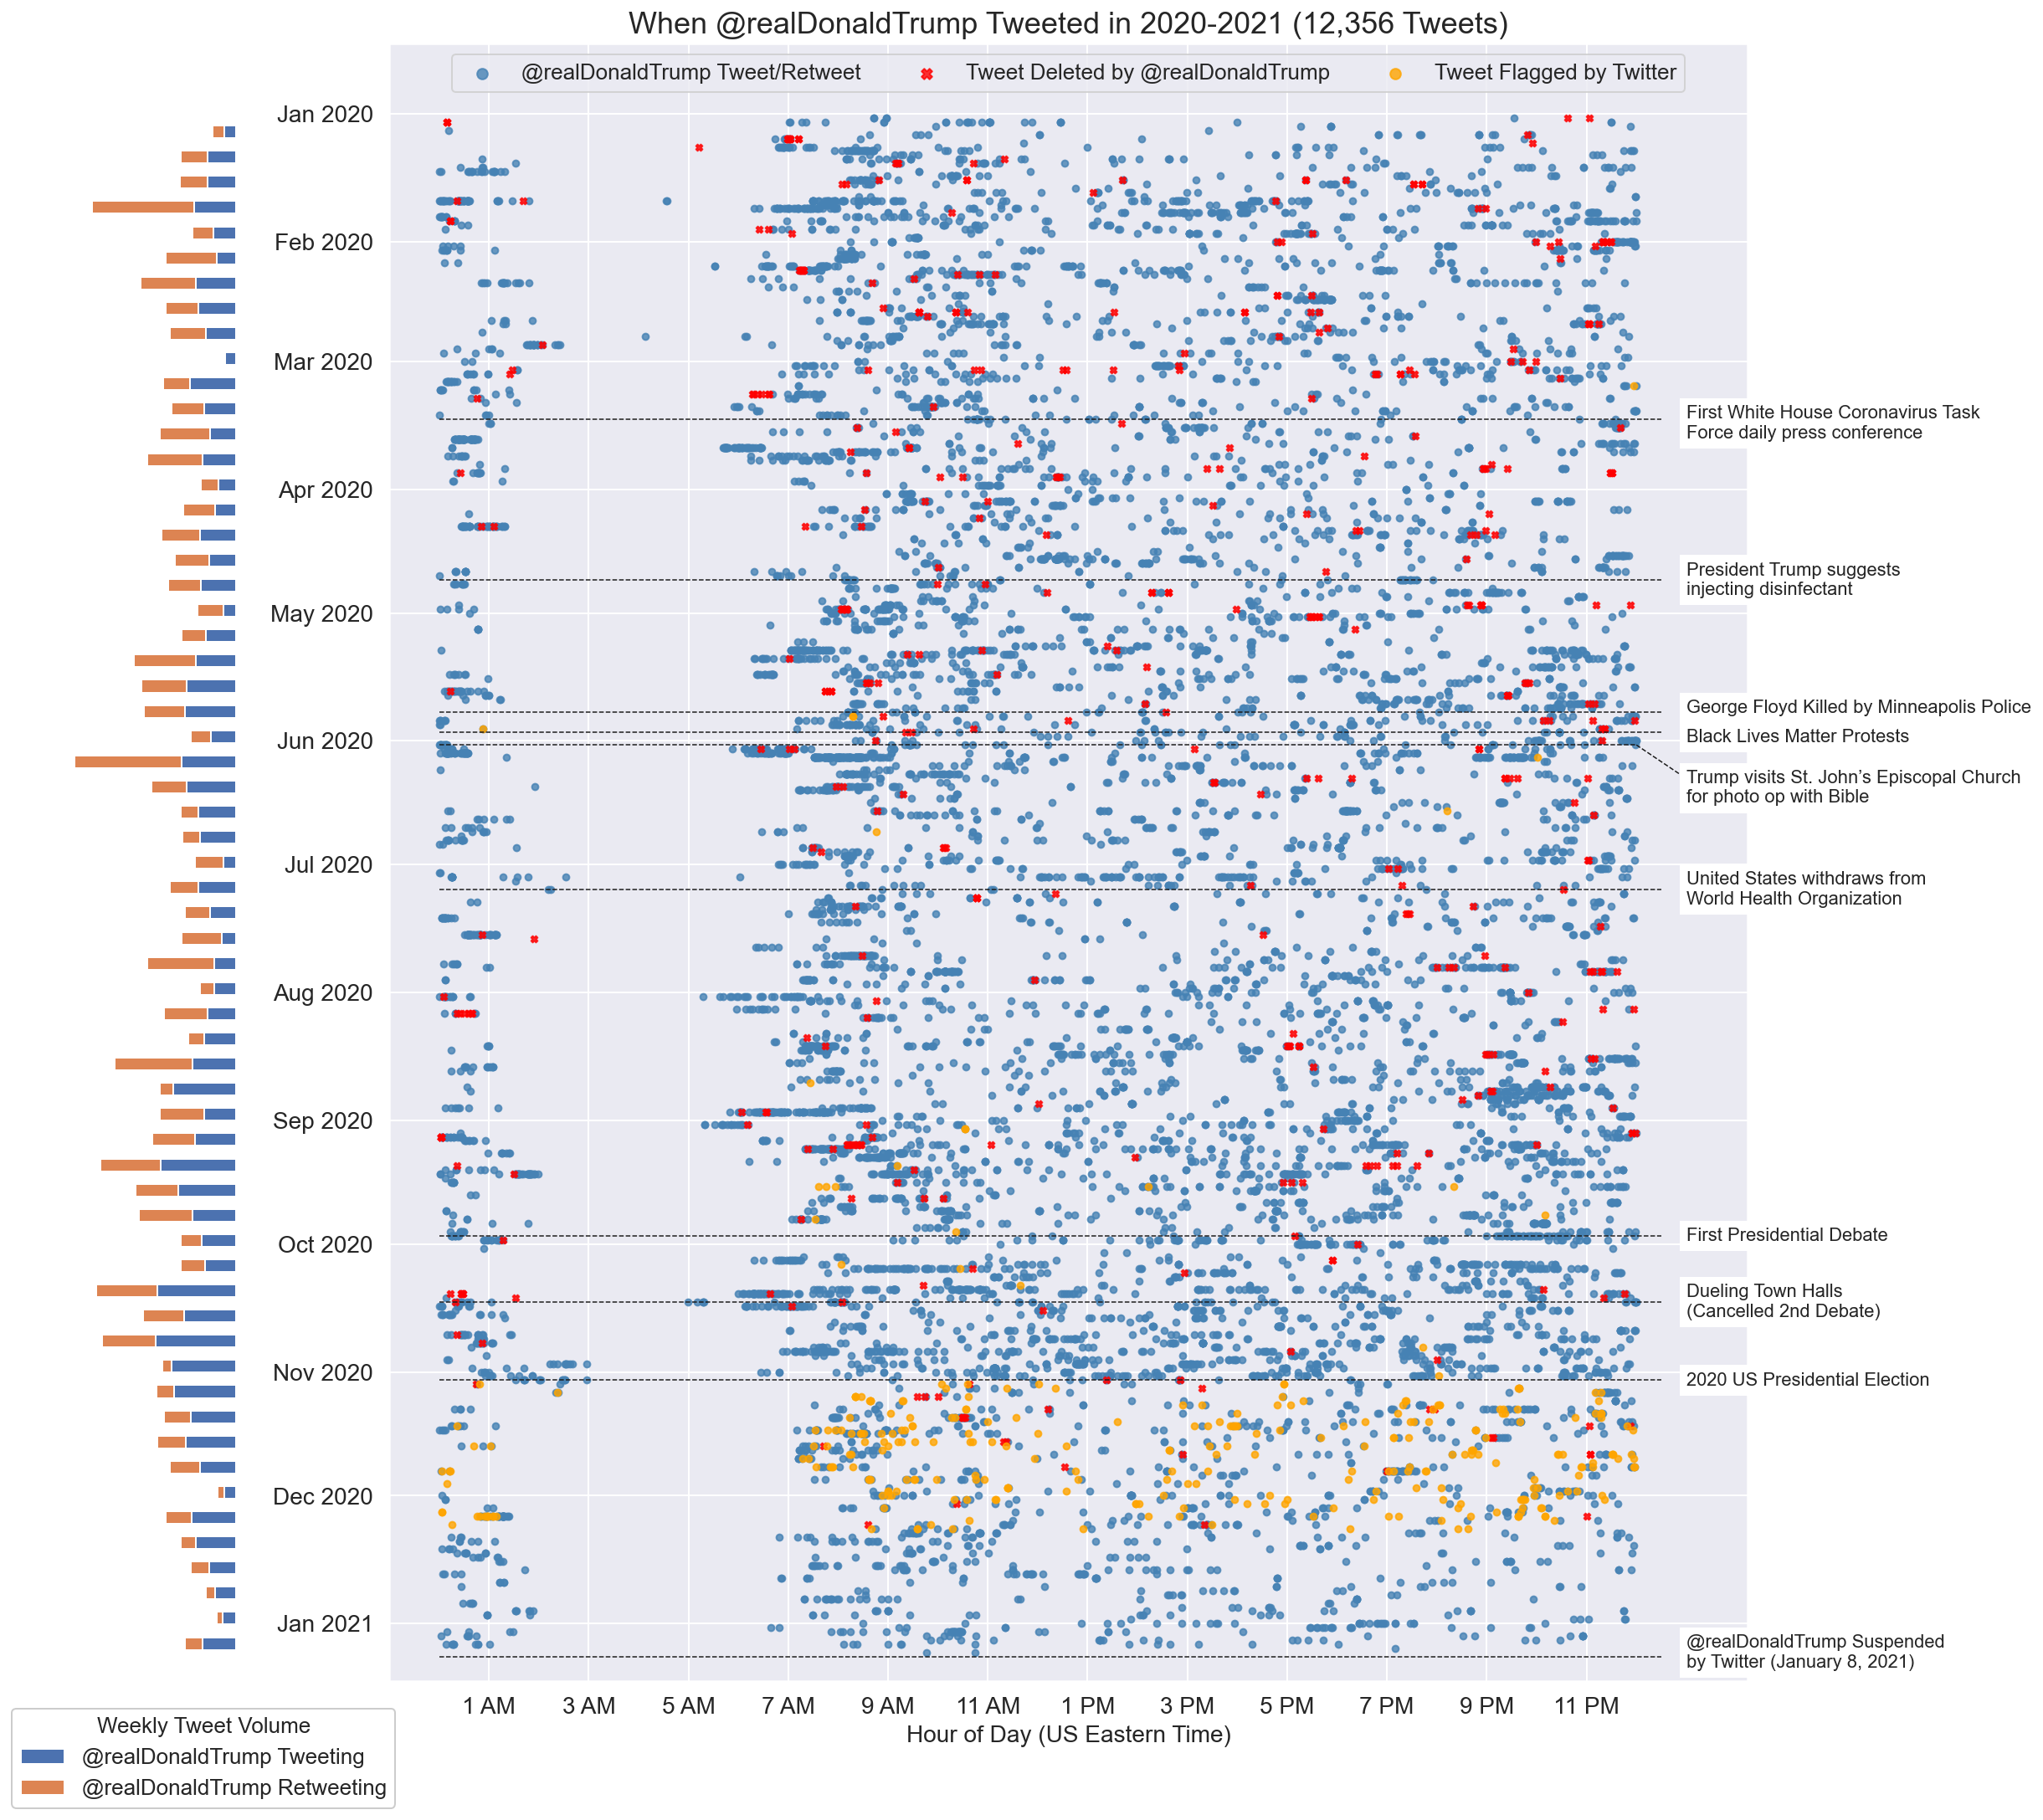

In [29]:
sns.set_style('darkgrid')
figsize=(18,18)
fig = plt.figure(figsize=figsize)
widths  = [1, 8]
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax2 = fig.add_subplot( gs[0] )
ax  = fig.add_subplot( gs[1] )

_slice[ ~_slice.isDeleted & ~_slice.isFlagged ].plot.scatter(
    x='normed_to_2000',y='day', color='steelblue', s=15, alpha=0.8, marker='o', ax=ax, 
    label="@realDonaldTrump Tweet/Retweet")

_slice[ _slice.isDeleted ].plot.scatter(
    x='normed_to_2000',y='day', color='red', s=15, alpha=0.8, marker='X', ax=ax, 
    label="Tweet Deleted by @realDonaldTrump")

_slice[ _slice.isFlagged ].plot.scatter(
    x='normed_to_2000',y='day', color='orange', s=15, alpha=0.8, marker='o', ax=ax, 
    label="Tweet Flagged by Twitter")


# Annotate the plot
first_task_force_presser(ax)
bleach_comment(ax)
dueling_town_halls(ax)
first_debate_2020(ax)
election_2020(ax)
withdraw_from_WHO(ax)
trump_visits_church(ax)
george_floyd(ax)
blm(ax)
suspended(ax)

ax.invert_yaxis()
ax2.invert_yaxis()

ax.set_ylim( date(2021,1,15), date(2019,12,15))
ax2.set_ylim(date(2021,1,15), date(2019,12,15))

# Set the axis labels
ax.yaxis.set_major_locator(mdates.MonthLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y", tz=None));

ax.set_xticks(np.arange(datetime(2000,1,1,1,0,0), datetime(2000,1,1,23,55,59), timedelta(hours=2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-I %p", tz=None));

ax.set_xlim(datetime(1999,12,31, 23, 0, 0))

ax.tick_params(labelsize=14)

# Need to make the dots bigger in the legend
lgnd = ax.legend(ncol=4, fontsize=13, loc='upper center')
#change the marker size manually
for handle in lgnd.legendHandles:
    handle._sizes = [40]

ax.set_title("When @realDonaldTrump Tweeted in 2020-2021 ({:,} Tweets)".format(len(_slice)),
             fontsize=18)
ax.set_ylabel(None); ax.set_xlabel("Hour of Day (US Eastern Time)", fontsize=14);

print("{:,} tweets in total".format(len(_slice)))

add_weekly_volume(ax2)

And that's the same plot from [this post](https://post-mortem-realdonaldtrump.medium.com/post-mortem-of-realdonaldtrump-an-introduction-b98a5764437d)

But can we do some more?

_To check what words might be best to search for, use the search function on [TheTrumpArchive.com](https://www.thetrumparchive.com/)_

In [12]:
# Tweets in all capitals?
_slice['isCapital'] = _slice.text.str.isupper()

In [13]:
perfect_words    = set(['perfect','incredible','amazing', 'magnificent'])
phony_words      = set(['fake','phony','hoax'])

_slice['hasPhony']       = _slice.text.apply(lambda text: len(set(text.lower().split()) & phony_words)>0)
_slice['hasPerfect']     = _slice.text.apply(lambda text: len(set(text.lower().split()) & perfect_words)>0)
_slice['hasExclamation'] = _slice.text.apply(lambda text: '!' in text)

In [14]:
# What do our tweets look like now?
_slice.head(3)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,eastern_time,...,hour,day,week,month,year,normed_to_2000,isCapital,hasPhony,hasPerfect,hasExclamation
1,1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,False,2020-03-03 01:34:50-05:00,...,20,2020-03-02,2020-03-03,2020-03-15,2020,2000-01-01 20:34:50,False,False,False,True
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47,False,2020-01-17 03:22:47-05:00,...,22,2020-01-16,2020-01-11,2020-01-15,2020,2000-01-01 22:22:47,False,False,False,False
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,False,2020-09-12 20:10:58-04:00,...,16,2020-09-12,2020-09-04,2020-09-15,2020,2000-01-01 16:10:58,False,False,False,True


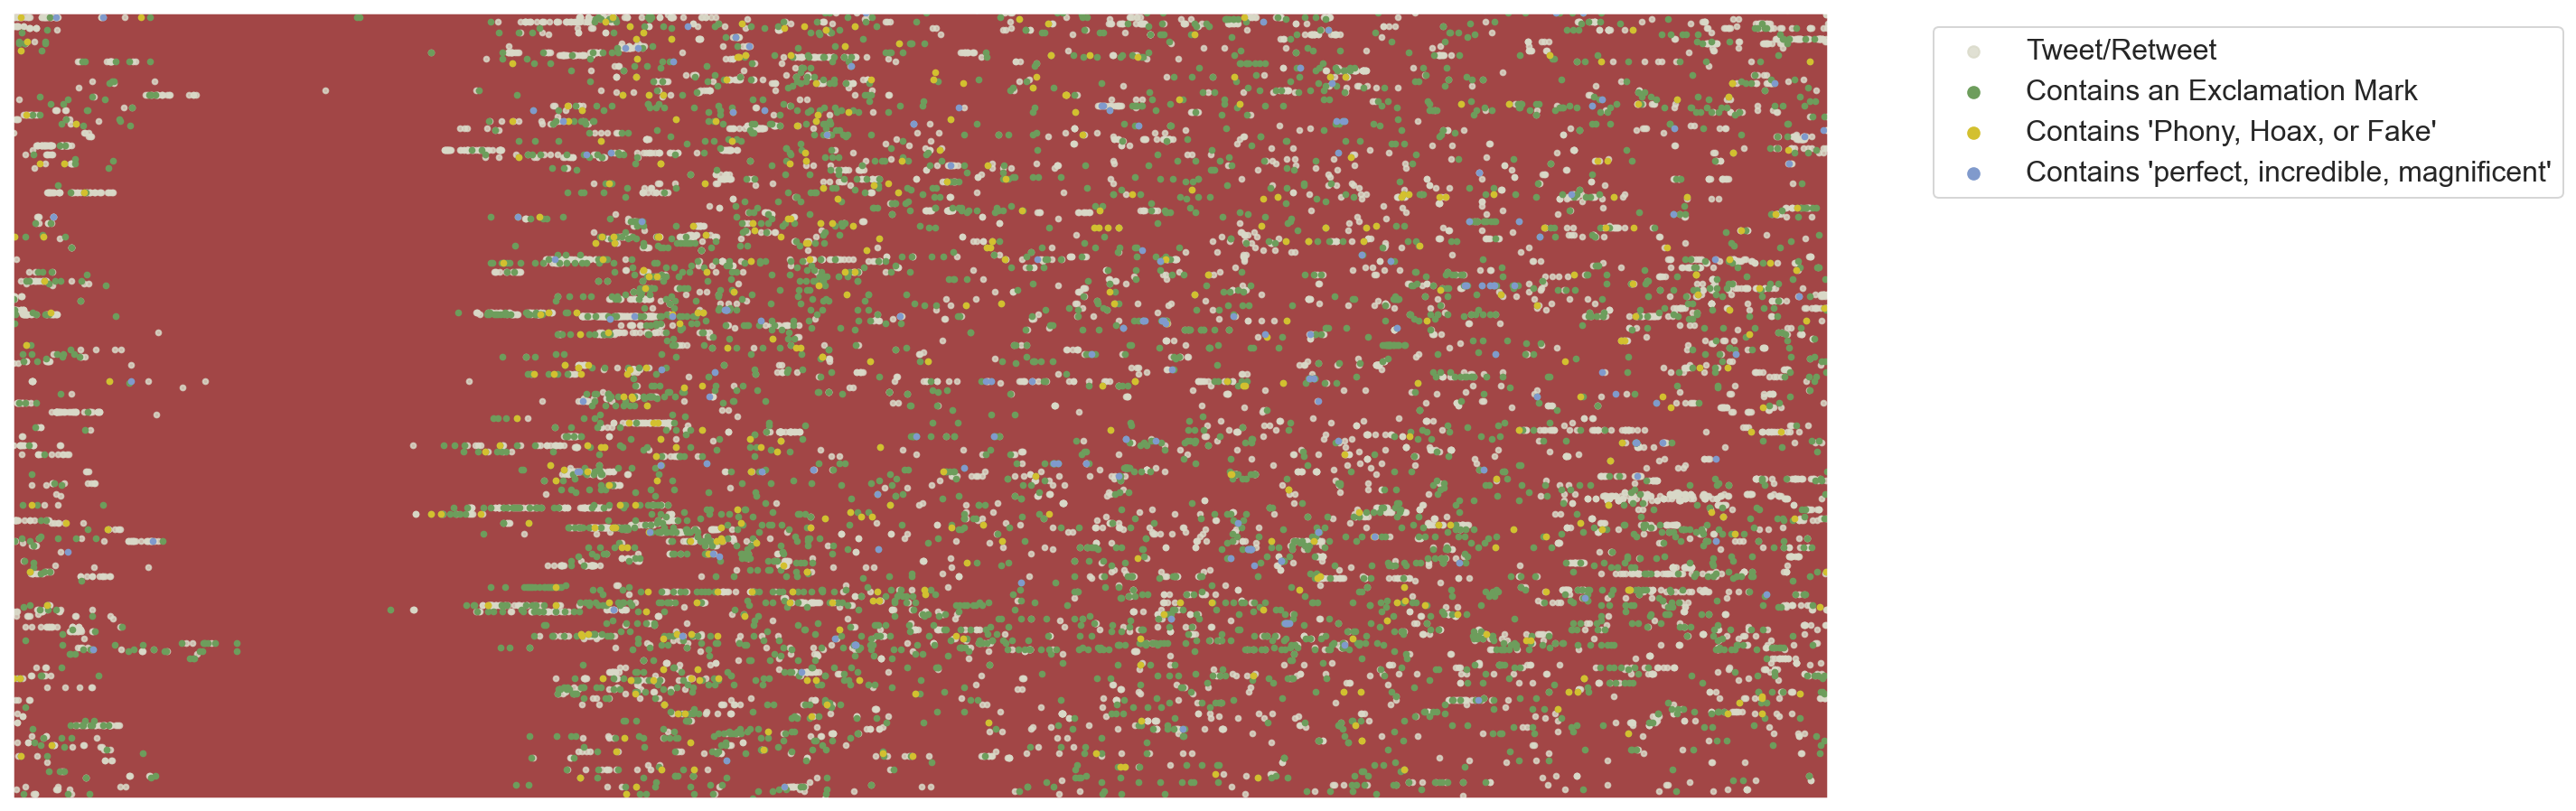

In [15]:
def make_stylized_plot(figsize=(18,8)):
    # Now let's make our first stylized plot:
    figsize=(18,8)
    sns.set_style('white')
    sns.set(rc={'axes.facecolor':'#a24646'})

    # "boring" tweets first as a base: 
    ax = _slice[
            ~ _slice.isCapital & ~_slice.hasPhony & ~_slice.hasPerfect & ~_slice.hasExclamation
        ].plot.scatter(
        x='normed_to_2000',y='day', color='#d9d9c8', s=8, alpha=0.8, marker='o', figsize=figsize, 
        label="Tweet/Retweet")

    #Now the more interesting tweets; color palette from: 
    #https://www.color-hex.com/color-palette/104603
    _slice[ _slice.hasExclamation & ~_slice.isRetweet].plot.scatter(
        x='normed_to_2000',y='day', color='#6d9d5c', s=8, alpha=1, marker='o', ax=ax,
        label="Contains an Exclamation Mark")

    _slice[ _slice.hasPhony].plot.scatter(
        x='normed_to_2000',y='day', color='#d3c02f', s=8, alpha=1, marker='o', ax=ax,
        label="Contains 'Phony, Hoax, or Fake'")

    _slice[ _slice.hasPerfect].plot.scatter(
        x='normed_to_2000',y='day', color='#809acc', s=8, alpha=1, marker='o', ax=ax,
        label="Contains 'perfect, incredible, magnificent'")

    lgnd = ax.legend(bbox_to_anchor =(1.05,1), facecolor='white', fontsize=16)
    for handle in lgnd.legendHandles:
        handle._sizes = [40]
    ax.invert_yaxis(); ax.set_xticks([]); ax.set_yticks([])
    ax.grid(False); ax.set_ylabel(None); ax.set_xlabel(None)
    ax.set_ylim(date(2021,1,8), date(2020,1,20))
    ax.set_xlim(datetime(2000,1,1,0, 0, 0),datetime(2000,1,1,23,59,59));
make_stylized_plot(figsize=(4,3))

It's a different color palette, highlighting specific tweets of interest and removing the axis; some type of abstract art?

### A closer look at time of day?

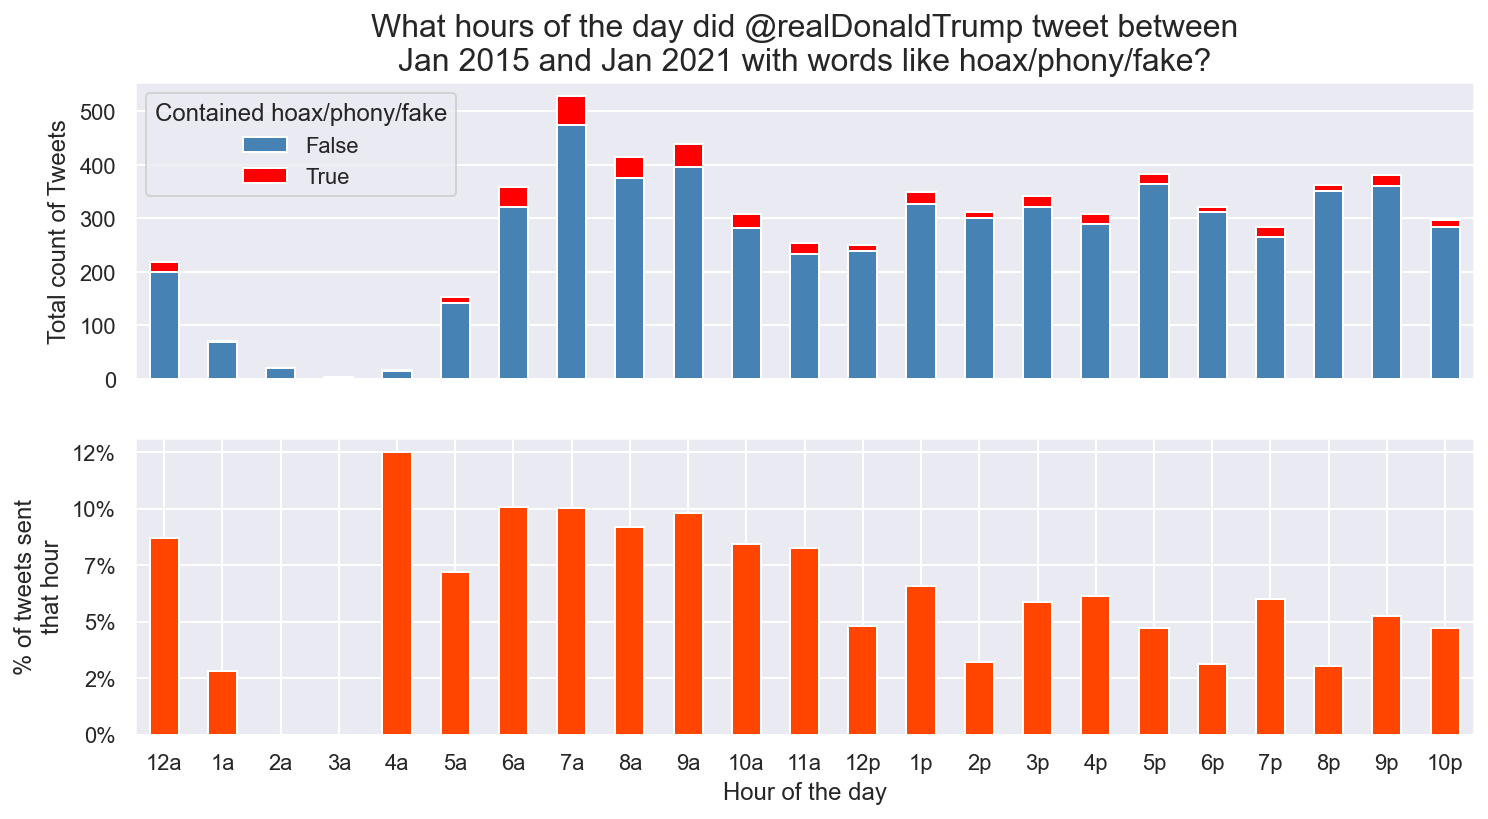

In [16]:
@ticker.FuncFormatter
def pretty_xaxis_hours(x,pos):
    if x==0:
        return "12a"
    if x==12:
        return "12p"
    elif x<12:
        return "{}a".format(x) 
    else:
        return "{}p".format(x-12)


def plot_type_of_tweet(column='hasPhony', words=phony_words):
    
    sns.set_style('darkgrid')

    fig, axes = plt.subplots(2,1, figsize=(12,6))
    ax1 = axes[0]; ax2 = axes[1]

    gb_hour = _slice[~_slice.isRetweet].groupby(['hour',column]).aggregate({'id':'count'}).unstack()
    gb_hour.columns = gb_hour.columns.get_level_values(1)
    gb_hour.plot.bar(stacked=True, ax=ax1, color=['steelblue','red'])

    ax1.set_title("What hours of the day did @realDonaldTrump tweet between\nJan 2015 and Jan 2021 with words like {}?".format(
        "/".join(words)), fontsize=16)
    ax1.set_ylabel("Total count of Tweets");
    ax1.set_xticks([]); ax1.set_xlabel(None);

    ax2 = (gb_hour[True] / (gb_hour[False] + gb_hour[True])*100).plot.bar(ax=ax2, color='orangered')
    # ax2.set_title("What % of @realDonaldTrump tweets contained the words: phony, hoax, or fake \ndepending on the time of day he tweeted?")
    ax2.set_ylabel("% of tweets sent\nthat hour");
    ax2.set_xlabel("Hour of the day");
    plt.xticks(rotation=0);

    ax1.legend(title="Contained {}".format("/".join(words)))

    ax2.xaxis.set_major_formatter(pretty_xaxis_hours);
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{}%".format(int(x))));
plot_type_of_tweet()

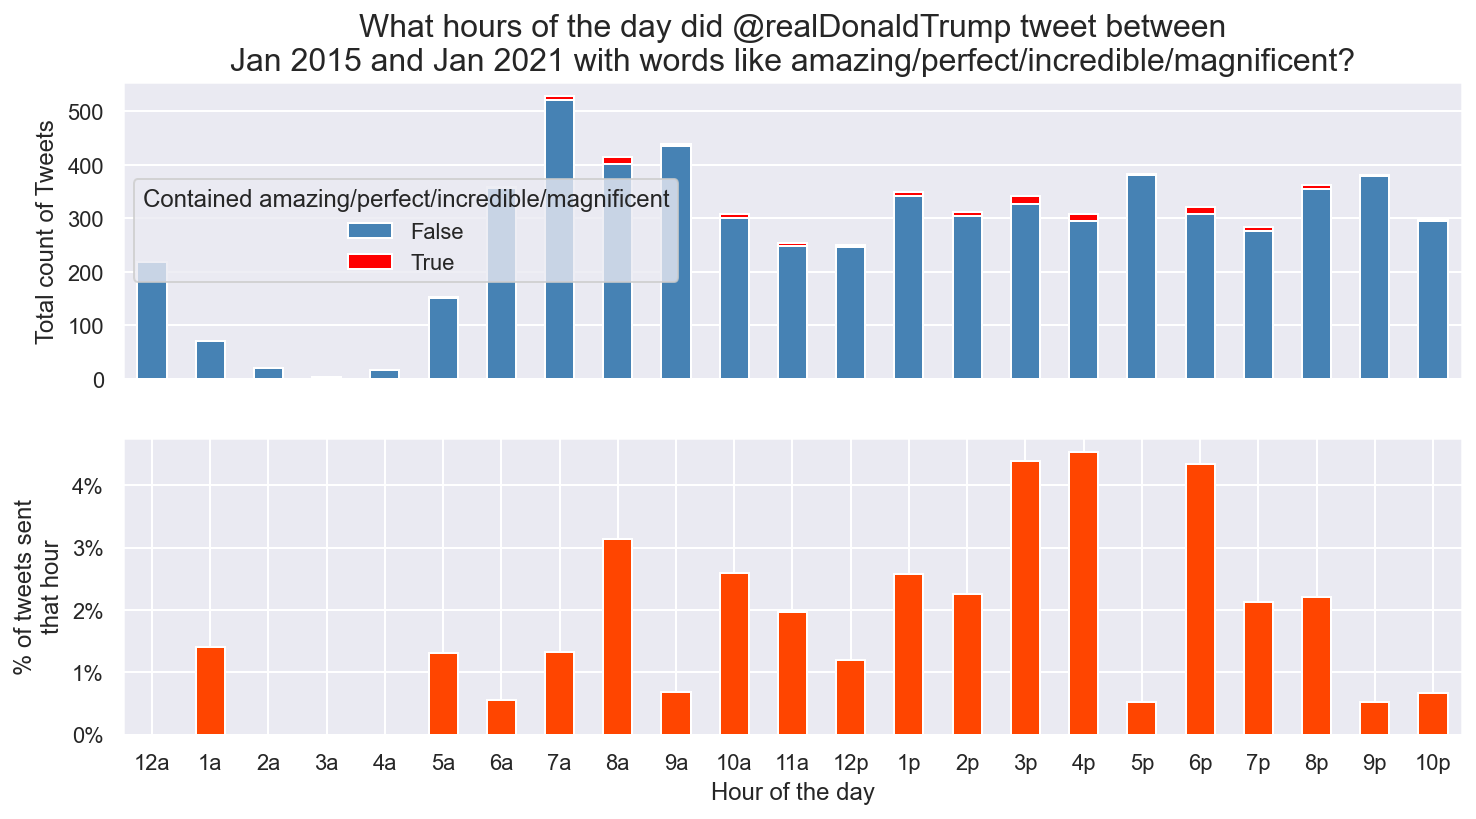

In [17]:
plot_type_of_tweet(column='hasPerfect', words=perfect_words)

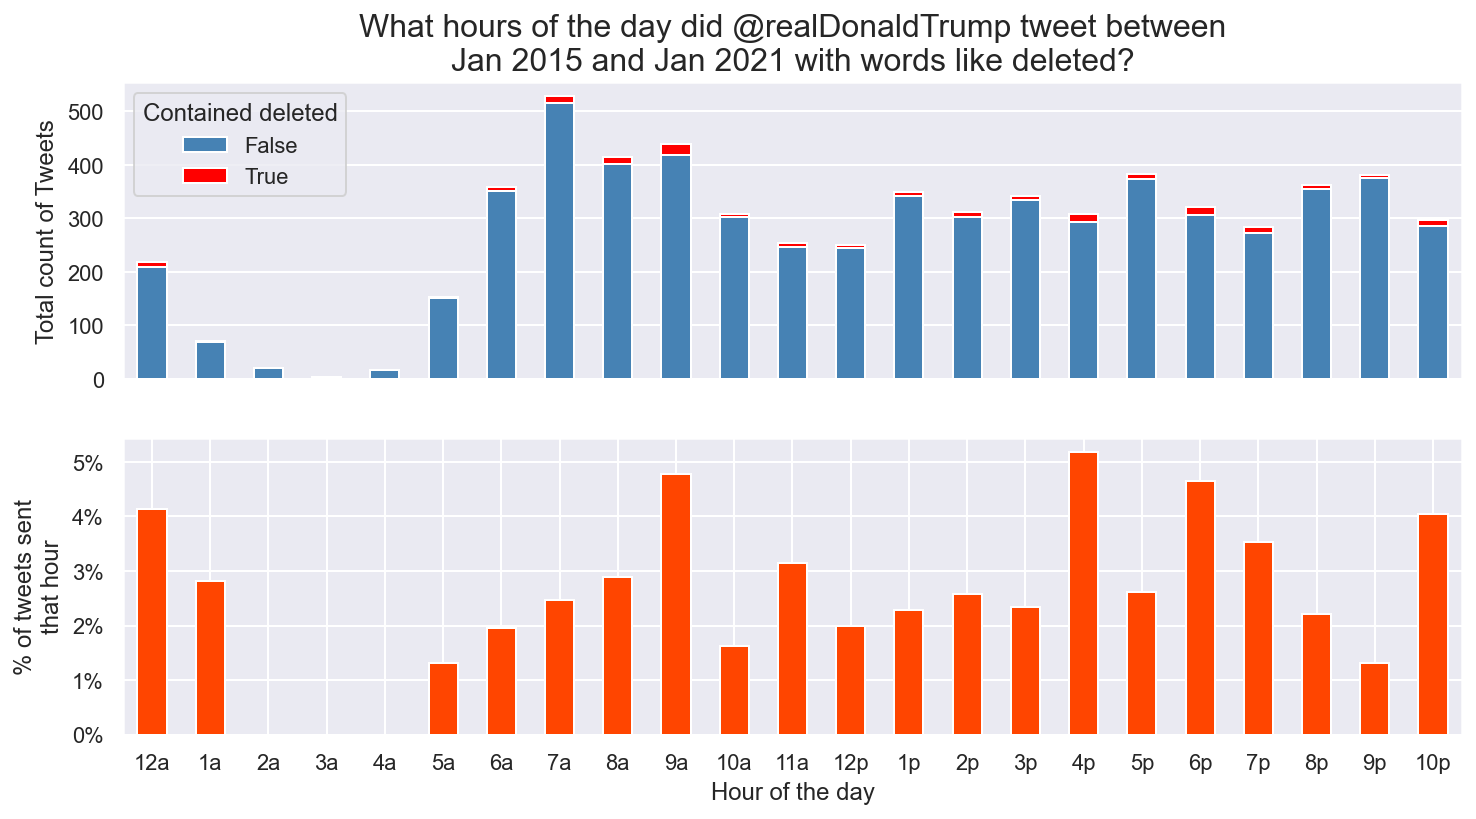

In [18]:
plot_type_of_tweet(column='isDeleted', words=["deleted"])

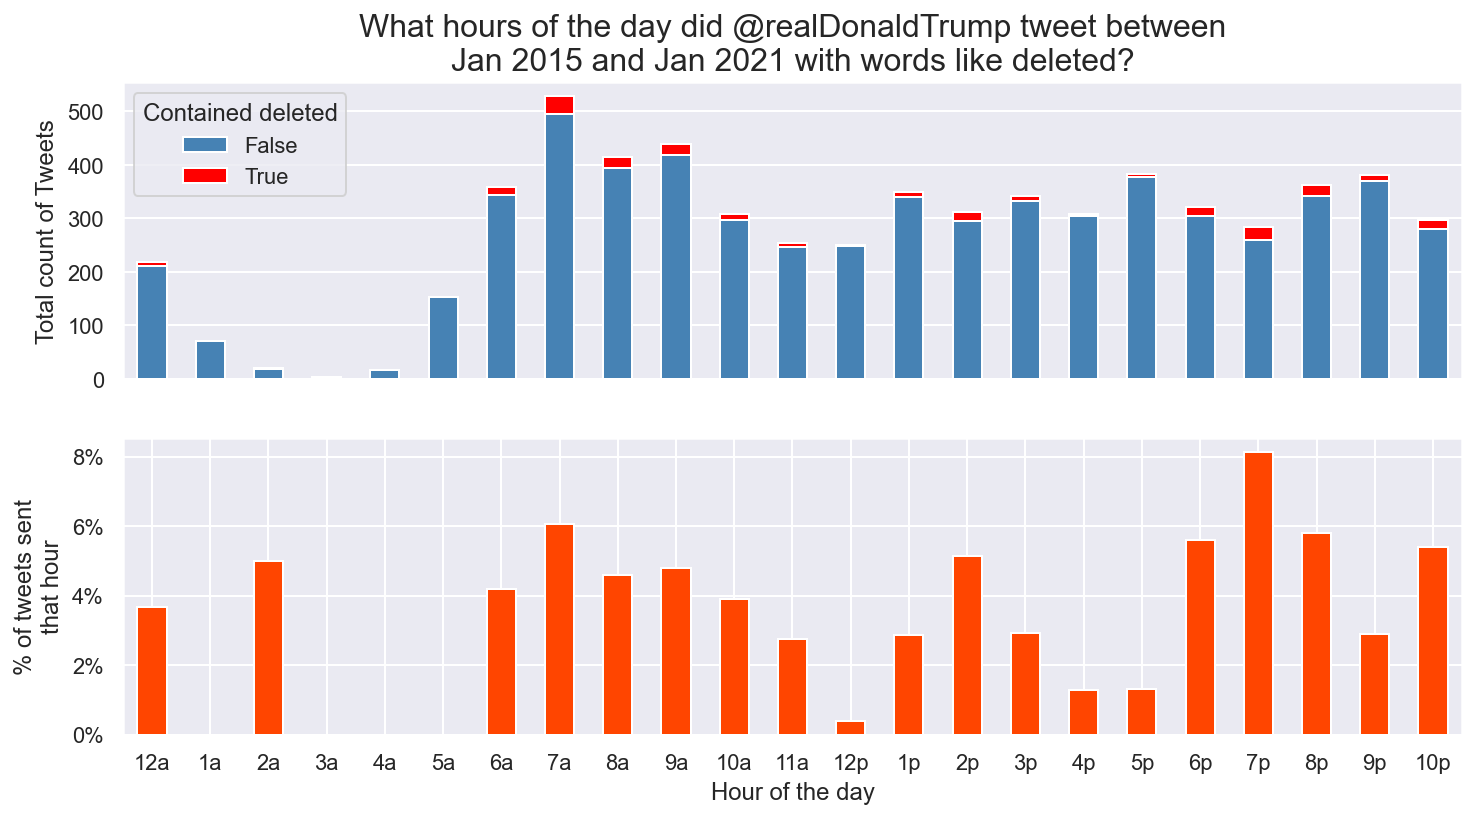

In [19]:
plot_type_of_tweet(column='isFlagged', words=["deleted"])

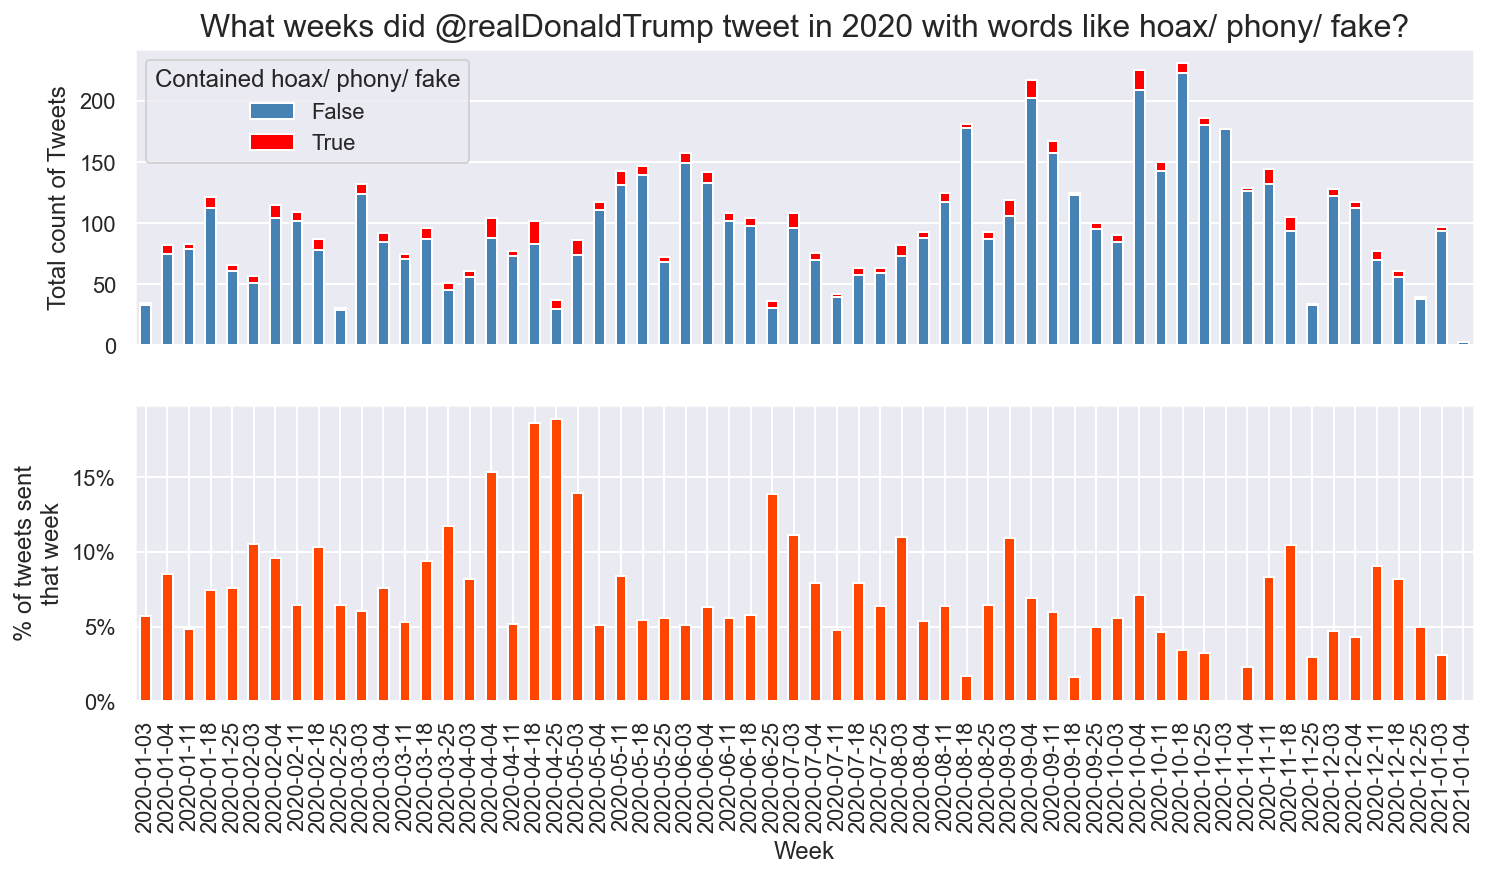

In [20]:
def plot_type_of_tweet_by_week(column='hasPhony', words=phony_words):
    
    sns.set_style('darkgrid')

    fig, axes = plt.subplots(2,1, figsize=(12,6))
    ax1 = axes[0]; ax2 = axes[1]

    gb_hour = _slice[~_slice.isRetweet].groupby(['week',column]).aggregate({'id':'count'}).unstack()
    gb_hour.columns = gb_hour.columns.get_level_values(1)
    gb_hour.plot.bar(stacked=True, ax=ax1, color=['steelblue','red'])

    ax1.set_title("What weeks did @realDonaldTrump tweet in 2020 with words like {}?".format(
        "/ ".join(words)), fontsize=16)
    ax1.set_ylabel("Total count of Tweets");
    ax1.set_xticks([]); ax1.set_xlabel(None);

    ax2 = (gb_hour[True] / (gb_hour[False] + gb_hour[True])*100).plot.bar(ax=ax2, color='orangered')
    # ax2.set_title("What % of @realDonaldTrump tweets contained the words: phony, hoax, or fake \ndepending on the time of day he tweeted?")
    ax2.set_ylabel("% of tweets sent\nthat week");
    ax2.set_xlabel("Week");
    plt.xticks(rotation=90);

    ax1.legend(title="Contained {}".format("/ ".join(words)))
    
#     ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"));
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{}%".format(int(x))));
plot_type_of_tweet_by_week()

It was really once he took office when started using these terms

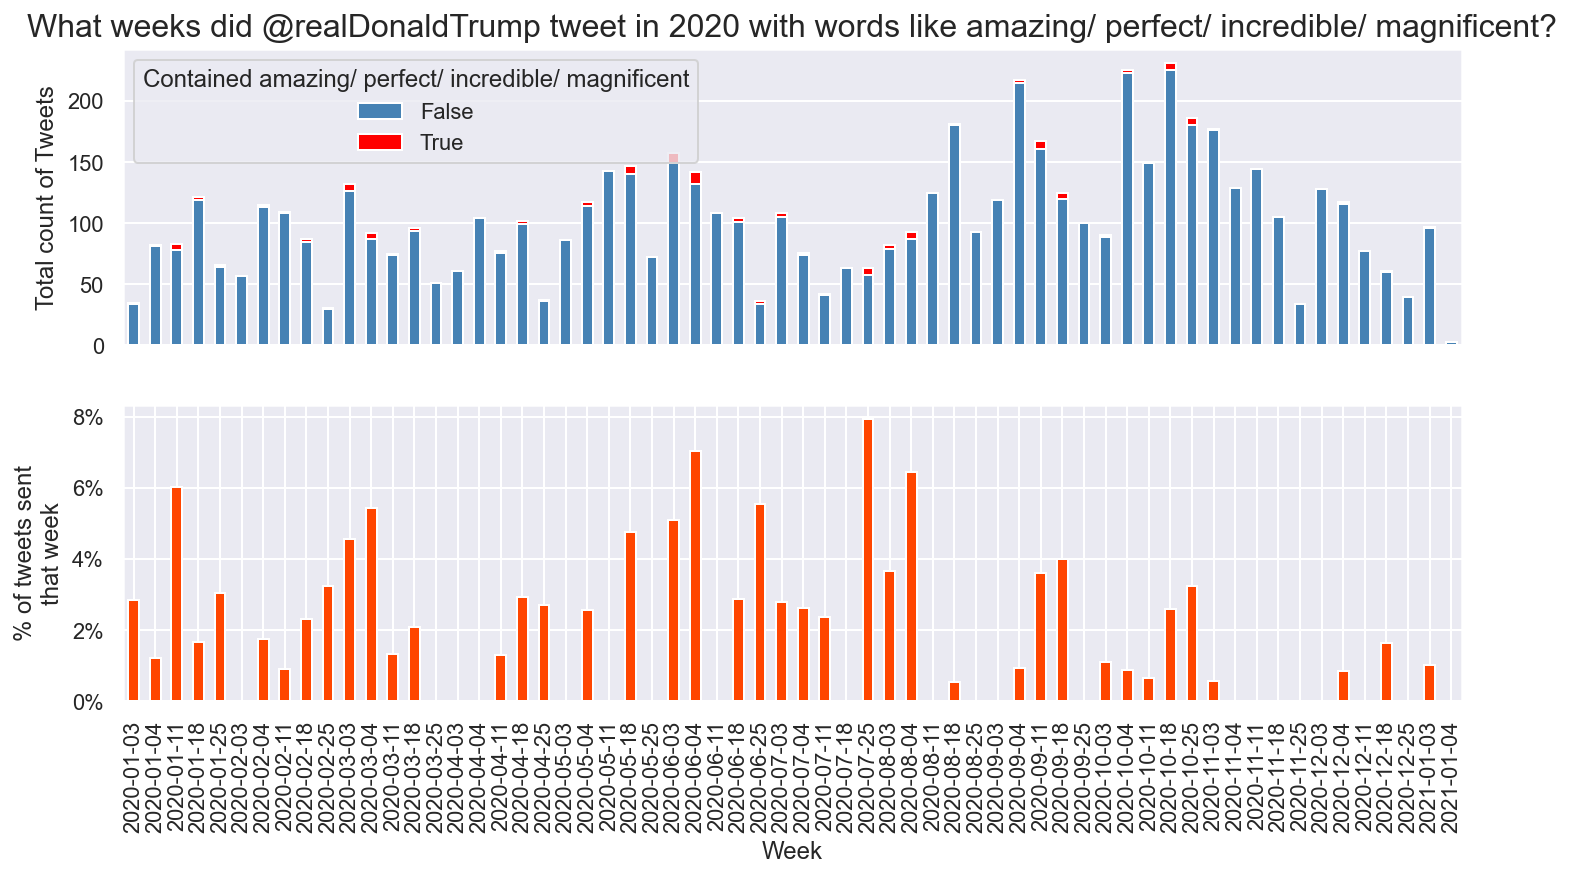

In [21]:
plot_type_of_tweet_by_week(column='hasPerfect', words=perfect_words)

## What about comparing the flagged tweets to the words election, stolen, rigged?

In [22]:
election = set(['stolen','rigged','steal','ballots','ballot','fraud'])
_slice['election']  = _slice.text.apply(lambda text: len(set(text.lower().split()) & election)>0)

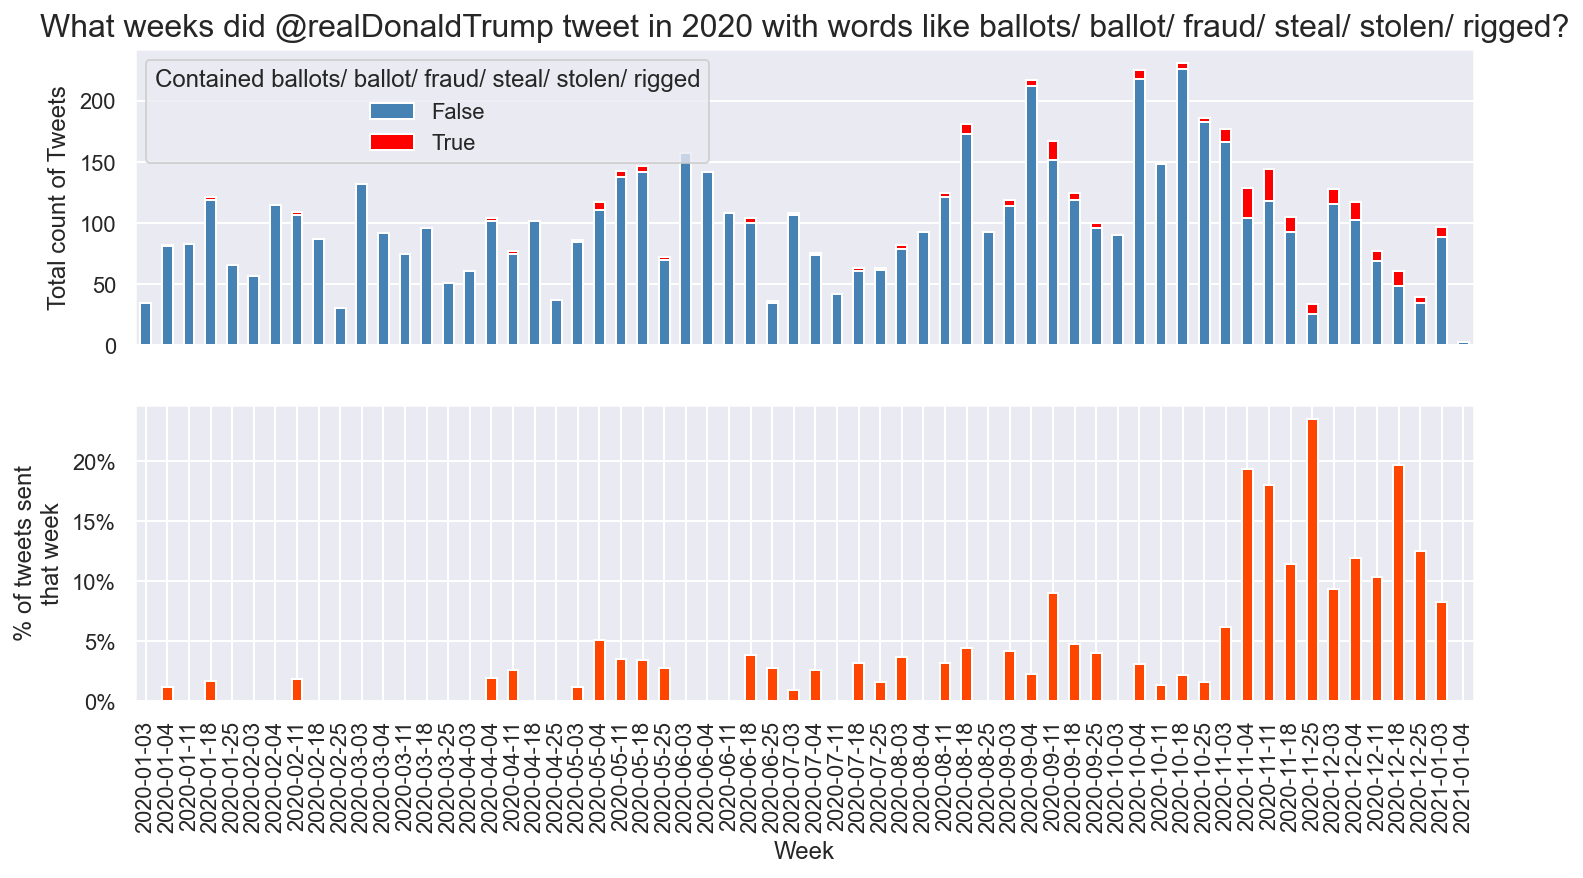

In [23]:
plot_type_of_tweet_by_week(column='election', words=election)

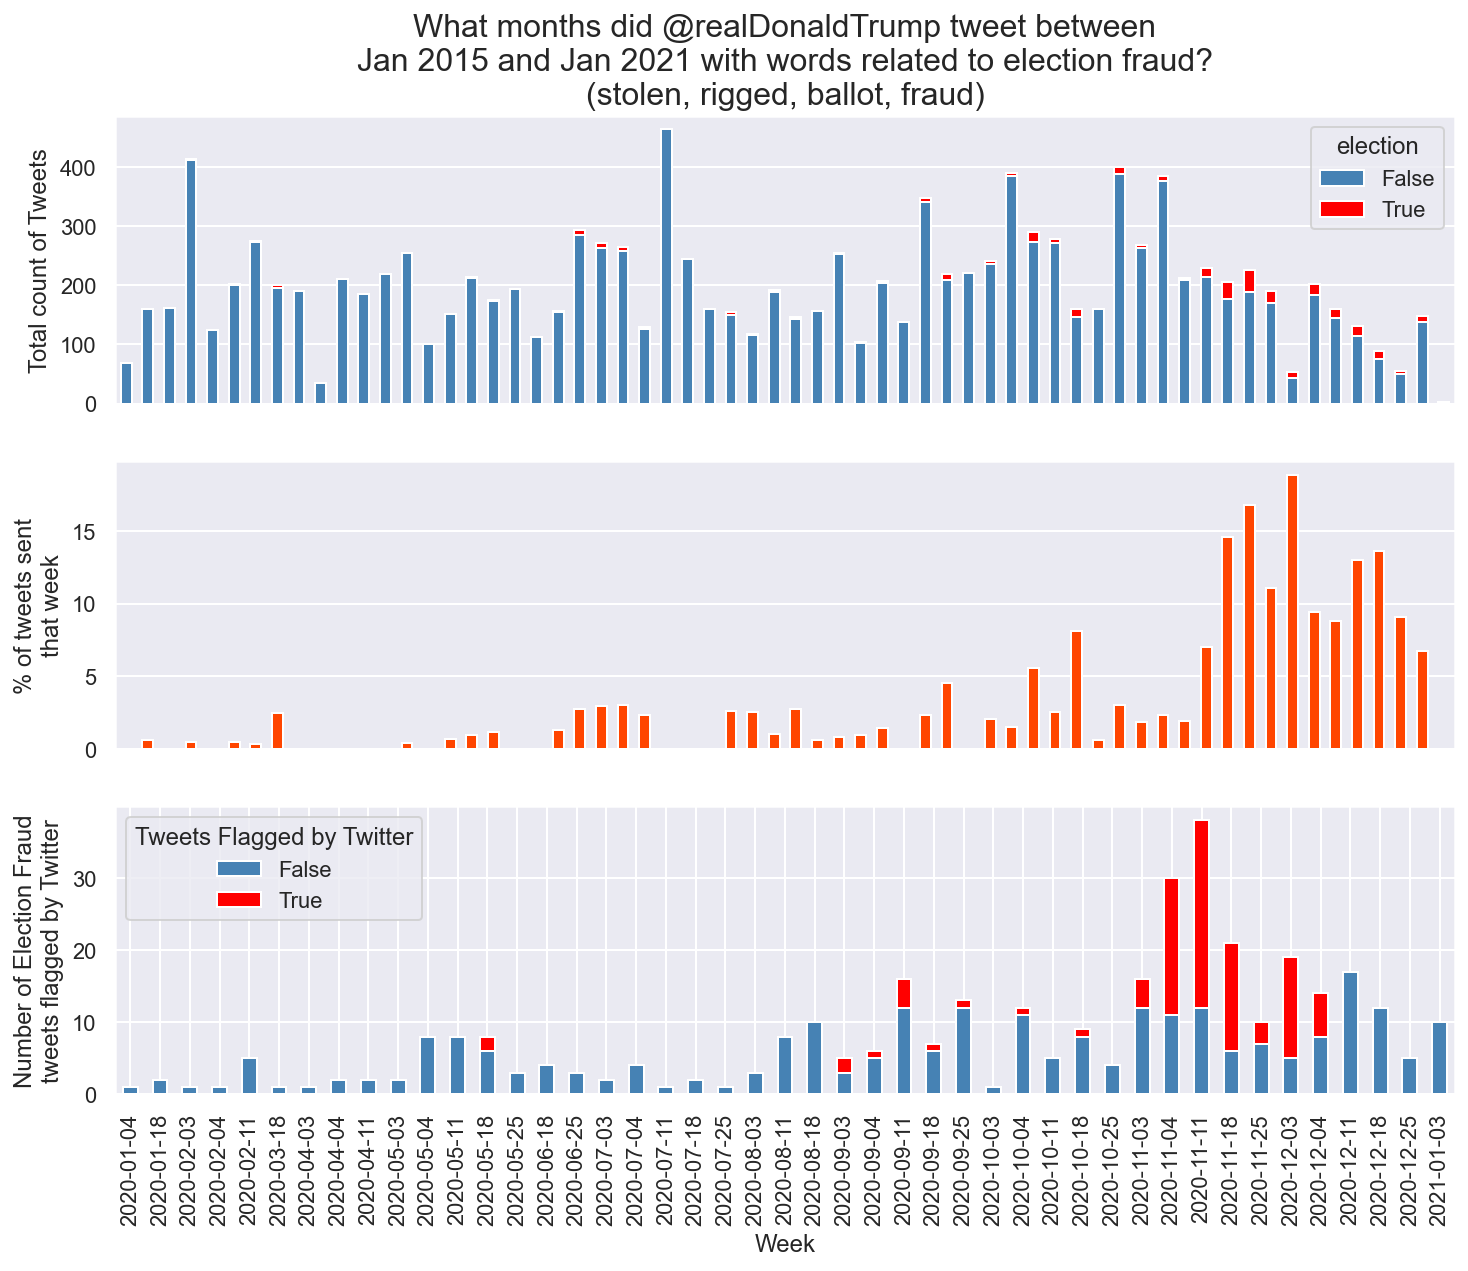

In [24]:
sns.set_style('darkgrid')

fig, axes = plt.subplots(3,1, figsize=(12,9))
ax1 = axes[0]; ax2 = axes[1]; ax3=axes[2]

gb_hour = _slice.groupby(['week','election']).aggregate({'id':'count'}).unstack()
gb_hour.columns = gb_hour.columns.get_level_values(1)
gb_hour.plot.bar(stacked=True, ax=ax1, color=['steelblue','red'])

ax1.set_title("What months did @realDonaldTrump tweet between\nJan 2015 and Jan 2021 with words related to election fraud?" + 
               "\n(stolen, rigged, ballot, fraud)" , fontsize=16)
ax1.set_ylabel("Total count of Tweets");
ax1.set_xticks([]); ax1.set_xlabel(None);

ax2 = (gb_hour[True] / (gb_hour[False] + gb_hour[True])*100).plot.bar(ax=ax2, color='orangered')
ax2.set_ylabel("% of tweets sent\nthat week");
ax2.set_xticks([]); ax2.set_xlabel(None);

election_ = _slice[_slice.election].groupby(['week','isFlagged']).aggregate({'id':'count'}).unstack()
election_.columns = election_.columns.get_level_values(1)
election_.plot.bar(stacked=True, ax=ax3, color=['steelblue','red'])
ax3.set_ylabel("Number of Election Fraud\ntweets flagged by Twitter")
ax3.legend(title="Tweets Flagged by Twitter", loc='upper left')
ax3.set_xlabel("Week")
plt.xticks(rotation=90);


In [25]:
# _slice_sorted = tweets.sort_values(by='tz_adjusted_date',ascending=True).reset_index()
# deltas = []
# for idx, t in _slice_sorted.iterrows():
#     if idx > 0:
#         deltas.append( ( t.tz_adjusted_date - _slice_sorted.iloc[idx-1].tz_adjusted_date ).total_seconds() )

# pd.Series(deltas).describe()

In [26]:
THRESHOLD = timedelta(seconds=10)

_slice_sorted = tweets[tweets.day>date(2015,1,1)].sort_values(by='tz_adjusted_date',ascending=True).reset_index()

frenzies = []

cur_frenzy = 0;
for idx, t in _slice_sorted.iterrows():
    if idx > 0:
        d = t.tz_adjusted_date - _slice_sorted.iloc[idx-1].tz_adjusted_date
        if d < THRESHOLD:
            cur_frenzy+=1
        else:
            if cur_frenzy>0:
                frenzies.append({'day':t.day, 'week':t.week, 'month':t.month, 'count':cur_frenzy})
                cur_frenzy=0

frenzies = pd.DataFrame(frenzies)

In [27]:
tmp

NameError: name 'tmp' is not defined

<ipython-input-220-ea0efb31b31c>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[(tweets.normed_to_2000 > datetime(2000,1,1,22,0,0)) |


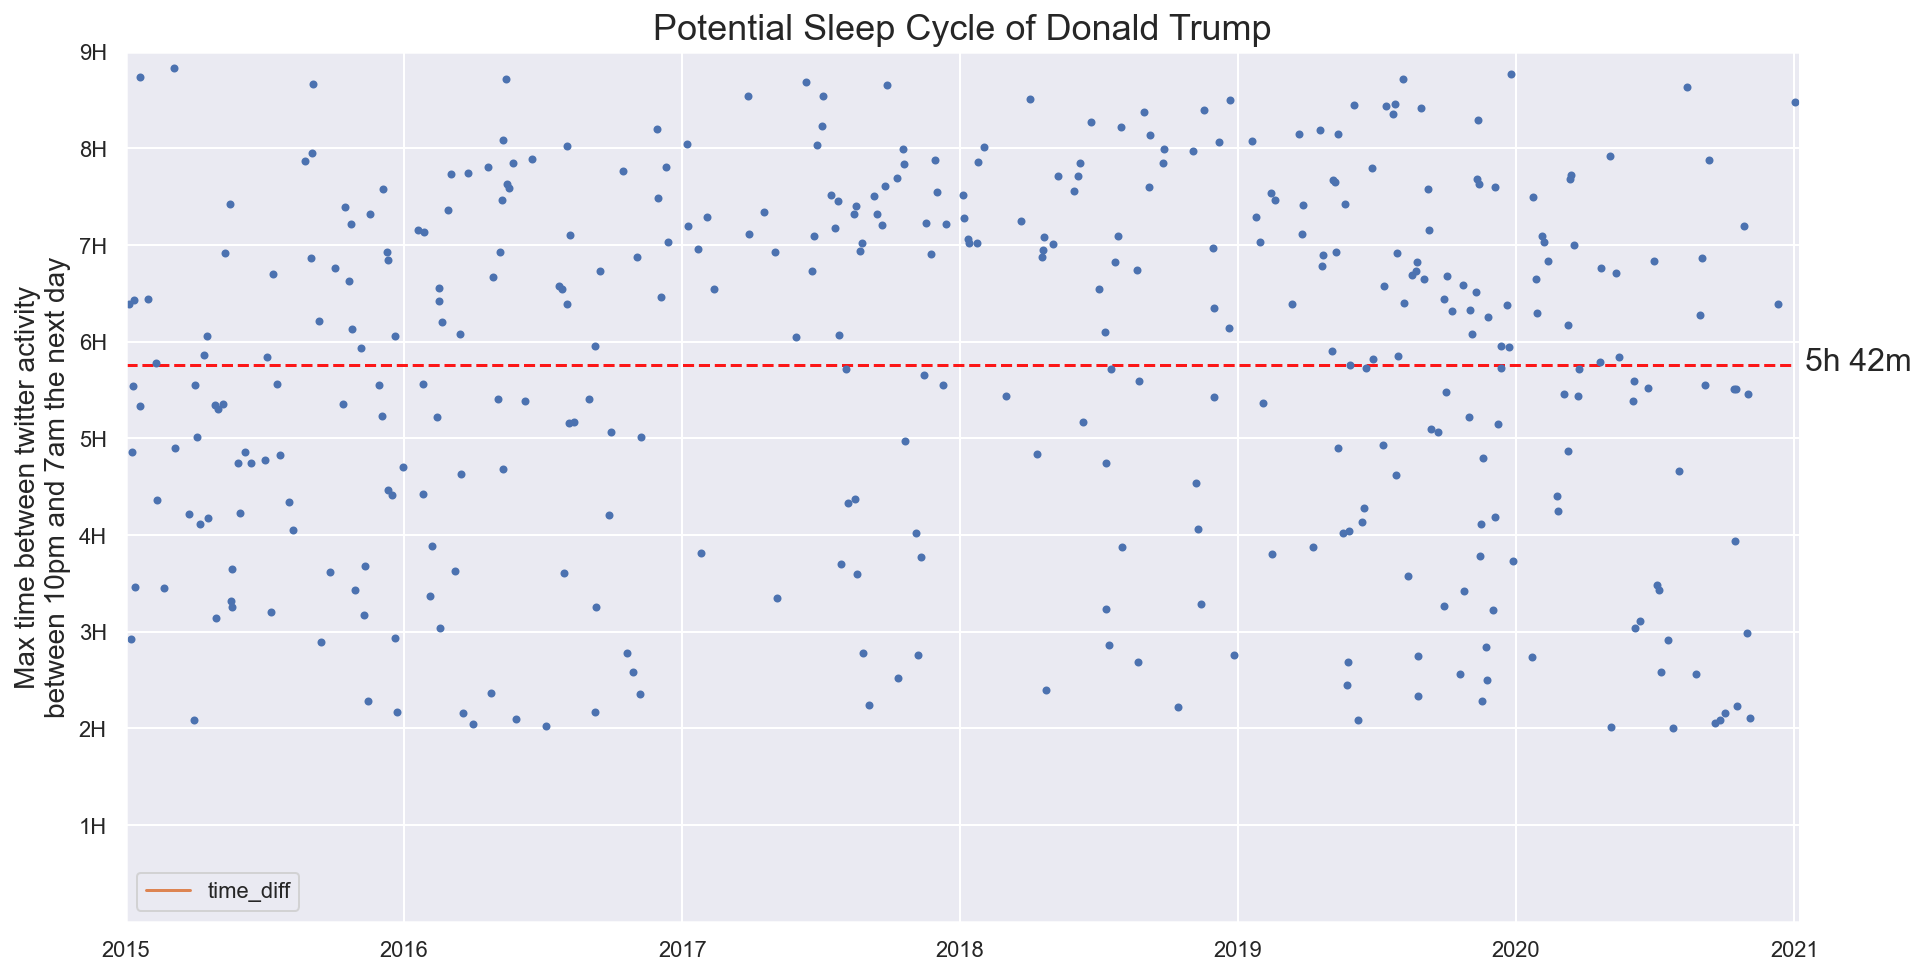

In [220]:
# What is his longest delta each day?
tmp = tweets[tweets.day>date(2015,1,1)]

tmp = tmp[(tweets.normed_to_2000 > datetime(2000,1,1,22,0,0)) | 
             (tweets.normed_to_2000 < datetime(2000,1,1,7,0,0)) ].sort_values(
    by='tz_adjusted_date',ascending=True).reset_index(drop=True)

tmp['time_diff'] = tmp['tz_adjusted_date'].diff()
tmp['time_diff'] = tmp['time_diff'].apply(lambda x: x.total_seconds()/3600)

# tmp[ (tmp['tz_adjusted_date'] < 12) & (tmp['time_diff'] > 1)]

dot_plot = tmp[(tmp.time_diff < 9) &
         (tmp.time_diff > 2)].groupby('day').aggregate({'time_diff':'max'}
            ).reindex(pd.date_range(start="2015-01-01",end="2021-01-08"))

ax = dot_plot.plot(figsize=(15,8), legend=None, style=".")

dot_plot.rolling(7).mean().plot(ax=ax)
# 
ax.set_yticks([1,2,3,4,5,6,7,8,9])

ax.set_ylim(0,9);
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{}H".format(x)));

ax.set_title("Potential Sleep Cycle of Donald Trump", fontsize=18)
ax.set_ylabel("Max time between twitter activity\nbetween 10pm and 7am the next day", fontsize=14);
ax.set_xlabel(None);

ax.hlines(xmin=date(2015,1,1), xmax=date(2021,1,1), y=5.759394, color='red', alpha=0.9, linestyle='--')

ax.text(y=5.7, x=date(2021,1,15), s="5h 42m", fontsize=16);


In [186]:
tmp[(tmp.time_diff < 9) &
         (tmp.time_diff > 2)].time_diff.describe()

count    403.000000
mean       5.591709
std        1.971249
min        2.001111
25%        3.873889
50%        5.905278
75%        7.216667
max        8.830556
Name: time_diff, dtype: float64

In [162]:
tmp[(tmp.time_diff < 9) &
         (tmp.time_diff > 2)].groupby('day').aggregate({'time_diff':'max'}
            ).mean()

time_diff    5.759394
dtype: float64

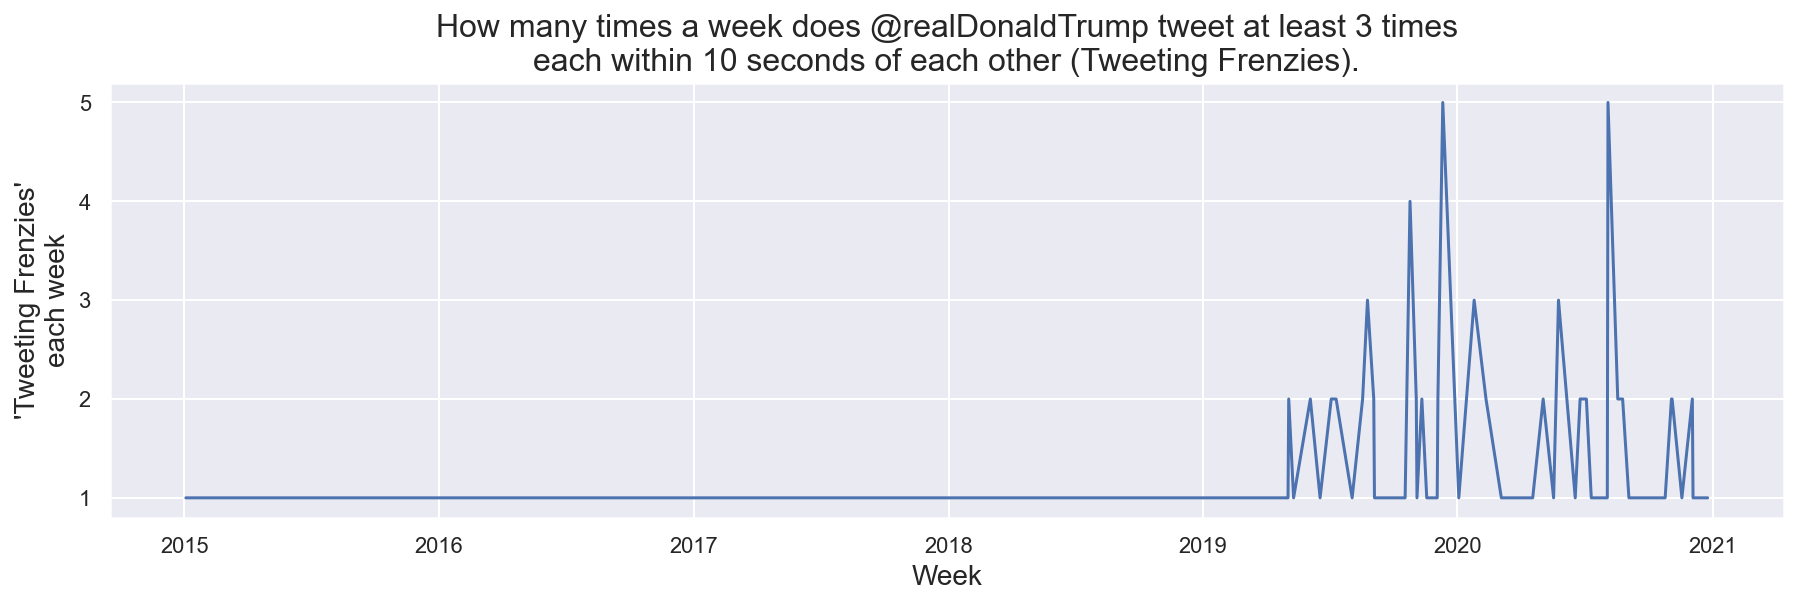

In [117]:
ax = frenzies[frenzies['count']>2].groupby('week').aggregate({"count":"count"}
    ).plot(figsize=(15,4), legend=None)
ax.set_ylabel("'Tweeting Frenzies'\neach week", fontsize=14)
ax.set_xlabel("Week", fontsize="14")
ax.set_yticks([1,2,3,4,5])
ax.set_title("How many times a week does @realDonaldTrump tweet at least 3 times\neach within 10 seconds of each other (Tweeting Frenzies).", fontsize=16);



In [249]:
frenzies[frenzies['count']>2].groupby('week').aggregate({"count":"count"}
    ).head(25)

,count
week,
2015-01-03,1
2018-04-11,1
2018-05-18,1
2018-07-11,1
2018-07-25,1
2018-08-25,1
2019-05-03,1
2019-05-04,2
2019-05-11,1


# Any correlations to COVID numbers?

In [163]:
covid_data = pd.read_csv('national-history.csv')
covid_data.head(2)
covid_data['day'] = covid_data.date.apply(lambda d: pd.Timestamp(d).date())

In [189]:
trump_sums = _slice.groupby('day').aggregate({'id':'count','isRetweet':sum})
trump_sums['original_tweets'] = trump_sums.id - trump_sums.isRetweet 
trump_sums.head(2)

,id,isRetweet,original_tweets
day,,,
2020-01-02,7,2,5
2020-01-03,31,18,13


In [199]:
trump_and_covid = covid_data.join(trump_sums, on='day', how='inner').set_index('day')
trump_and_covid.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease,id,isRetweet,original_tweets
day,,,,,,,,,,,,,,,,,,,,
2021-01-08,2021-01-08,360047.0,3780,38432.0,23912.0,4705,131921.0,720748.0,103325191.0,675322,3756.0,7908.0,21752049.0,295121,56,268060647,2163546,2,0,2
2021-01-07,2021-01-07,356267.0,4079,38236.0,23821.0,5312,132370.0,716043.0,102649869.0,573875,3748.0,7900.0,21456928.0,272043,56,265897101,1946262,1,0,1
2021-01-06,2021-01-06,352188.0,3902,38064.0,23708.0,6607,132474.0,710731.0,102075994.0,493339,3739.0,7946.0,21184885.0,250184,56,263950839,1638284,22,6,16
2021-01-05,2021-01-05,348286.0,3484,37841.0,23509.0,4290,131195.0,704124.0,101582655.0,677123,3718.0,7976.0,20934701.0,219075,56,262312555,1714814,18,6,12
2021-01-04,2021-01-04,344802.0,1547,37586.0,23435.0,3892,128210.0,699834.0,100905532.0,527737,3692.0,7930.0,20715626.0,179571,56,260597741,1581745,18,1,17


In [200]:
trump_and_covid.corr()

,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease,id,isRetweet,original_tweets
death,1.000000,0.511628,0.994666,0.598650,0.361048,0.716959,0.998531,0.970614,0.859635,0.986081,0.379734,0.948649,0.844076,0.431091,0.957650,0.954131,-0.018013,-0.112340,0.138190
deathIncrease,0.511628,1.000000,0.351345,0.793470,0.671184,0.761422,0.449662,0.450801,0.448061,0.281646,0.774643,0.622644,0.721089,0.489790,0.570947,0.574939,-0.181314,-0.182539,-0.084495
inIcuCumulative,0.994666,0.351345,1.000000,0.630144,0.203090,0.714833,0.997986,0.991988,0.792419,0.993108,0.403955,0.972324,0.860085,NaN,0.987459,0.952712,-0.075308,-0.158858,0.087882
inIcuCurrently,0.598650,0.793470,0.630144,1.000000,0.452119,0.962266,0.621362,0.642100,0.365996,0.558331,0.921433,0.753906,0.826549,NaN,0.690960,0.609006,-0.230519,-0.188206,-0.189002
hospitalizedIncrease,0.361048,0.671184,0.203090,0.452119,1.000000,0.459897,0.293614,0.313336,0.402024,0.197295,0.407140,0.450261,0.545291,0.439450,0.432064,0.465911,-0.146474,-0.161111,-0.045288
hospitalizedCurrently,0.716959,0.761422,0.714833,0.962266,0.459897,1.000000,0.733639,0.729423,0.520600,0.638560,0.854951,0.829319,0.895443,NaN,0.769090,0.725025,-0.262434,-0.229134,-0.186994
hospitalizedCumulative,0.998531,0.449662,0.997986,0.621362,0.293614,0.733639,1.000000,0.977176,0.835346,0.990638,0.396355,0.956721,0.849805,0.243992,0.968202,0.954460,-0.055168,-0.154601,0.127275
negative,0.970614,0.450801,0.991988,0.642100,0.313336,0.729423,0.977176,1.000000,0.800792,0.993967,0.396400,0.977686,0.880240,0.184984,0.996558,0.951253,-0.076047,-0.170303,0.108423
negativeIncrease,0.859635,0.448061,0.792419,0.365996,0.402024,0.520600,0.835346,0.800792,1.000000,0.785568,0.167248,0.780879,0.744447,0.562083,0.806654,0.916601,-0.014590,-0.106845,0.148318
onVentilatorCumulative,0.986081,0.281646,0.993108,0.558331,0.197295,0.638560,0.990638,0.993967,0.785568,1.000000,0.295204,0.951256,0.827363,NaN,0.982881,0.946746,-0.066498,-0.164890,0.116023


<AxesSubplot:xlabel='day'>

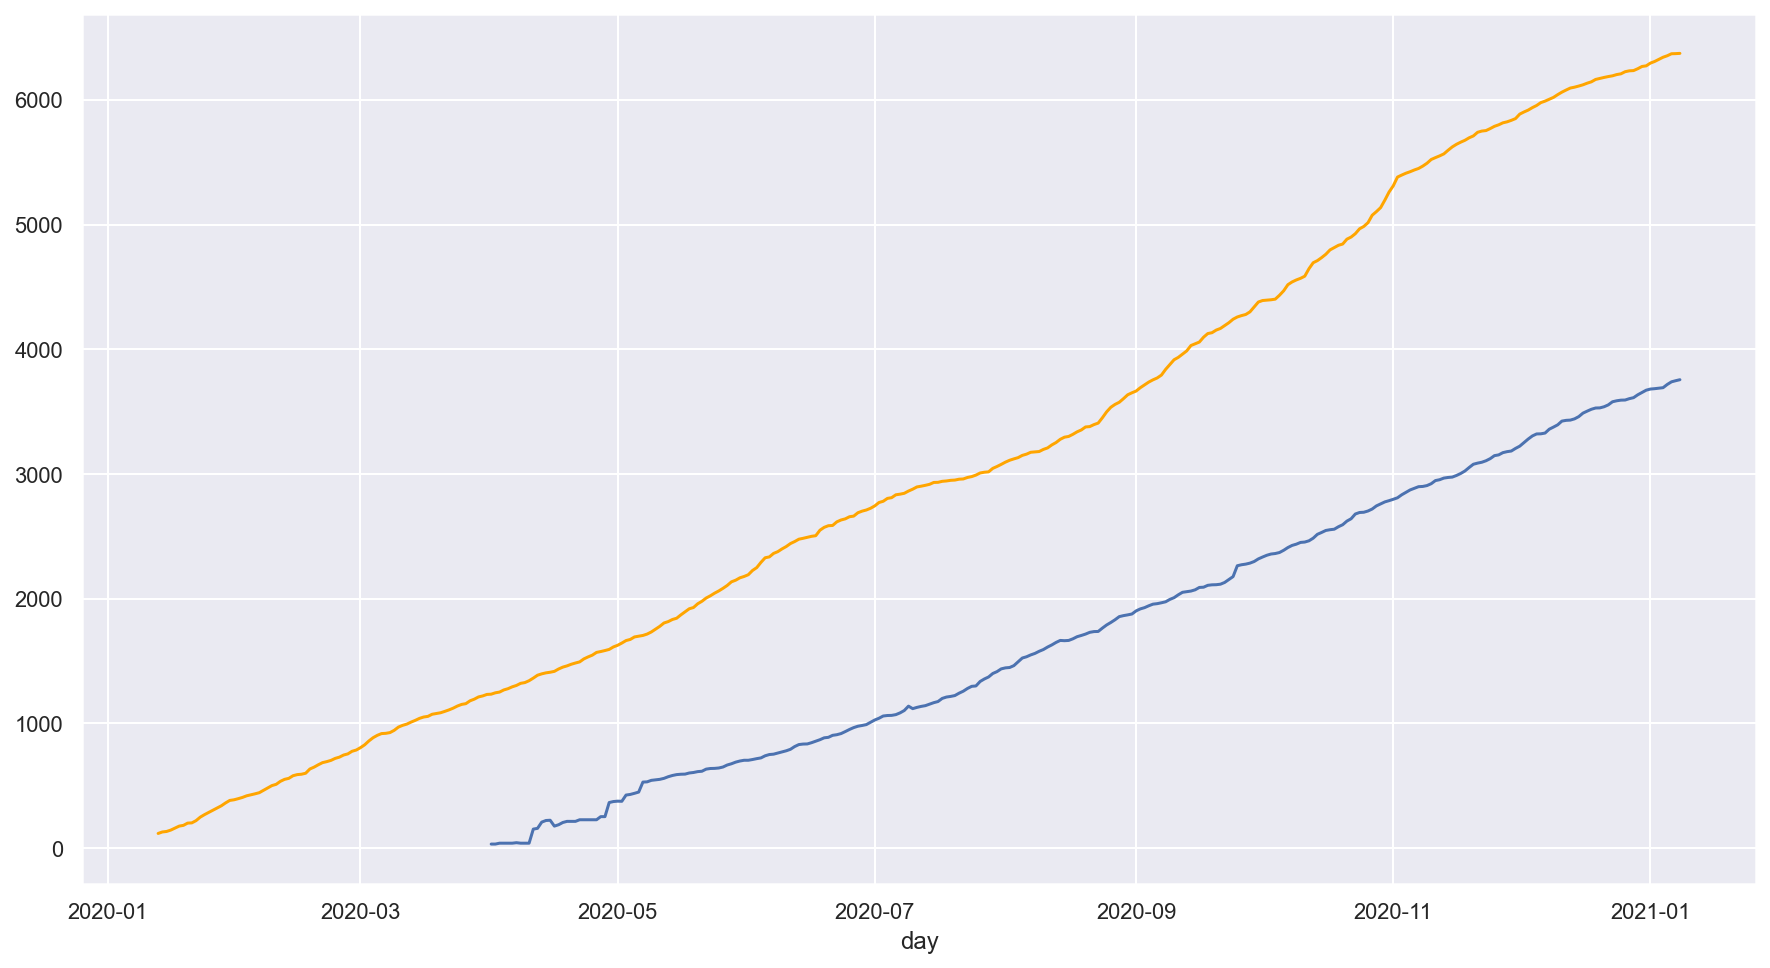

In [198]:
ax = (trump_and_covid.onVentilatorCumulative).plot(figsize=(15,8), label="1,000s of COVID deaths in the US")

trump_and_covid['original_tweets'].plot(ax=ax, color='orange', label="Trump's 2020 Tweet count (cumulative)")
# ax.legend(loc='upper left')
# ax2.legend(loc='center left')

# ax2.set_ylabel("Trump's 2020 Tweet Count");
# ax.set_ylabel("1000s of COVID deaths in the US");